In [5]:
import pickle
import networkx as nx
from glycowork.motif.draw import GlycoDraw
from glycowork.motif.graph import  glycan_to_nxGraph
from glycowork.motif.graph import  subgraph_isomorphism


In [8]:
flex_data_path = '/Users/xakdze/PycharmProjects/GlyContact_analyses/data/glycan_graphs.pkl'

def load_data():
    """Load glycan flexibility data and binding data."""
    with open(flex_data_path, 'rb') as file:
        flex_data = pickle.load(file)
    # binding_df = pd.read_csv(flex_data_path)
    return flex_data
flex_data = load_data()

In [52]:
def map_daniel_to_luc_graph(matched_glycan, flex_data, daniel_selected_nodes):
    """
    Map selected nodes from a Daniel graph to a corresponding Luc graph based on a predefined mapping.
    """
    daniel_graph = glycan_to_nxGraph(matched_glycan)
    luc_graph = flex_data.get(matched_glycan)

    # Define the mapping logic between Daniel and Luc graphs
    def create_mapping():
        if len(daniel_graph.nodes) % 2 == 1:
            dan_max = len(daniel_graph.nodes)
            luc_max = len(luc_graph.nodes)
            map_dict = dict(zip(range(0, dan_max, 2), range(luc_max, 0, -1)))
        else:
            dan_max = len(daniel_graph.nodes) - 1
            luc_max = len(luc_graph.nodes)
            map_dict = dict(zip(range(0, dan_max, 2), range(luc_max, 0, -1)))
        return map_dict
    # Generate the mapping dictionary
    map_dict = create_mapping()

    # Map the selected nodes from the Daniel graph to the Luc graph
    luc_selected_nodes = []
    for node in daniel_selected_nodes:
        if node in map_dict:
            luc_selected_nodes.append(map_dict[node])

    return luc_selected_nodes

In [63]:
##def process_glycan_with_motifs(
matched_glycan= "Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc"
#matched_glycan= "Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc"
properties= {'motif': ['Fuc'], 'termini_list': [['t']]}
#properties= {"motif": ["Fuc(a1-2)Gal", "GalNAc"], "termini_list": [["t", "f"], ["t"]]}
flex_data=  load_data()

"""
Process a glycan string to find nodes matching binding motifs and calculate metrics.
Handles both single and multiple binding motifs.
"""
matching_monosaccharides, sasa_weighted, flexibility_weighted, found_motifs = [], [], [], []

motifs = properties["motif"]
termini_list = properties["termini_list"]

for motif, termini in zip(motifs, termini_list):
    print("motif: ", motif)
    print("termini: ", termini)

# Perform subgraph isomorphism
    is_present, matched_nodes = subgraph_isomorphism(
        matched_glycan, motif,
        return_matches=True,
        termini_list=termini
    )
    print(f"subgraph isomorphism: matched_nodes: {matched_nodes}")
    if not is_present:
        continue


    found_motifs.append(motif)
    print("")
    print(f"matched_glycan: {matched_glycan}")
    print(f"Processing motif: {motif}")

    matched_nodes = [node for sublist in matched_nodes for node in sublist] \
        if isinstance(matched_nodes[0], list) else matched_nodes


print(f"matched_nodes: {matched_nodes}")

motif:  Fuc
termini:  ['t']
subgraph isomorphism: matched_nodes: [[0], [4], [8]]

matched_glycan: Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc
Processing motif: Fuc
matched_nodes: [0, 4, 8]


In [54]:
matched_mono = [matched_nodes[index] for index in range(0, len(matched_nodes), 2)]
print(f"matched_mono: {matched_mono}")

selected_mono = map_daniel_to_luc_graph(matched_glycan, flex_data, matched_nodes)
print(f"selected_mono: {selected_mono}")


# Extract attributes from graph nodes
graph = flex_data.get(matched_glycan)
if graph and hasattr(graph, "nodes"):
    #print(f"graph.nodes: {graph.nodes}")
    #print(f"graph.attributes: {graph.nodes(data=True)}")
    for mono in selected_mono:
        try:
            attributes = graph.nodes[mono]
            matching_monosaccharides.append(attributes.get("Monosaccharide", 0))
            sasa_weighted.append(attributes.get("Weighted Score", 0))
            flexibility_weighted.append(attributes.get("weighted_mean_flexibility", 0))
            print(f"matching_monosaccharides: {matching_monosaccharides}")
            print(f"mono attributes: {attributes}")
        except Exception as e:
            print(f"Error extracting attributes for node {mono} in glycan {matched_glycan}: {e}")


matched_mono: [0, 8]
selected_mono: [10, 8, 6]
matching_monosaccharides: ['Fuc(a1-3)']
mono attributes: {'Monosaccharide': 'Fuc(a1-3)', 'Mean Score': 1.8676189828198404, 'Median Score': 1.8176706893136725, 'Weighted Score': 1.9261586474572951, 'weighted_mean_flexibility': 16.641286591340865}
matching_monosaccharides: ['Fuc(a1-3)', 'Gal(b1-4)']
mono attributes: {'Monosaccharide': 'Gal(b1-4)', 'Mean Score': 1.7647929069120436, 'Median Score': 1.7578037350904197, 'Weighted Score': 1.7861381799561076, 'weighted_mean_flexibility': 15.575945445455453}
matching_monosaccharides: ['Fuc(a1-3)', 'Gal(b1-4)', 'Fuc(a1-3)']
mono attributes: {'Monosaccharide': 'Fuc(a1-3)', 'Mean Score': 1.81364550429862, 'Median Score': 1.891440232633613, 'Weighted Score': 1.8669023368021382, 'weighted_mean_flexibility': 22.883701009899013}


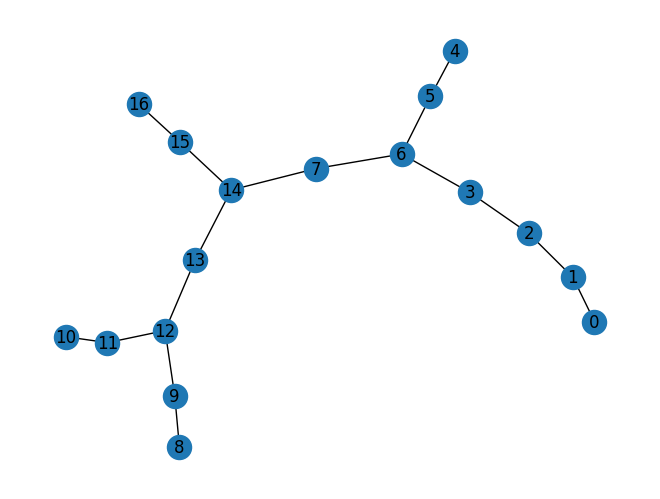

In [57]:
#Daniels graph
fuc_3 = glycan_to_nxGraph('Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc')
nx.draw(fuc_3, with_labels=True)

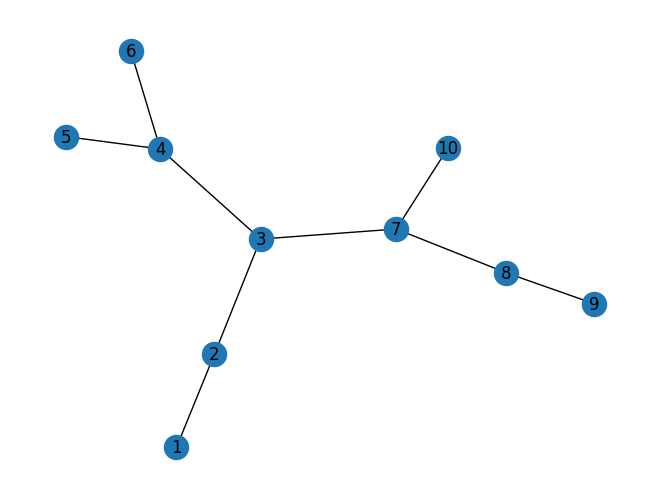

In [56]:
#Lucs graph
nx.draw(flex_data['Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc'] , with_labels=True)

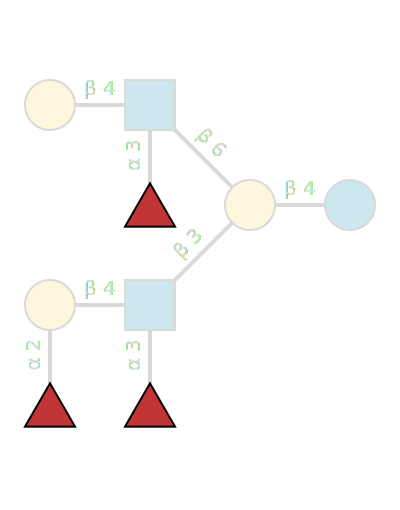

In [29]:
GlycoDraw('Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc', highlight_motif='Fuc')

In [19]:
def convert_pdb_graph_to_glycowork(g):
    """
    Converts a PDB-format graph to glycowork format.
    Args:
        g (nx.Graph): Input graph in PDB format with Monosaccharide and score attributes
    Returns:
        nx.Graph: Converted graph in glycowork format with monosaccharide/linkage split into separate nodes
    """
    import networkx as nx

    new_g = nx.Graph()

    # Find reducing end (node connected to -R node 1)
    reducing_end = None
    for n in g.neighbors(1):
        reducing_end = n
        break

    if reducing_end is None:
        raise ValueError("Could not find reducing end (node connected to -R)")

    # Get node list in DFS order starting from reducing end (excluding -R node)
    nodes = [n for n in nx.dfs_preorder_nodes(g, reducing_end) if n != 1]

    # Create mapping dict
    mapping = {}
    mapping[1] = []  # -R maps to nothing

    # Calculate highest node number
    max_num = 2 * (len(g.nodes) - 2)

    # Map reducing end to highest number
    mapping[reducing_end] = [max_num]

    # Map rest of nodes in reverse order
    curr_num = 0
    for node in reversed(nodes[1:]):  # Skip reducing end
        mapping[node] = [curr_num, curr_num + 1]
        curr_num += 2

    # Create nodes in new graph
    for old_node, new_nodes in mapping.items():
        if not new_nodes:  # Skip -R
            continue

        # Get numerical attributes
        attrs = {k: v for k, v in g.nodes[old_node].items()
                if k not in ['Monosaccharide', 'string_labels']}
        mono_link = g.nodes[old_node]['Monosaccharide']

        if len(new_nodes) == 1:  # Reducing end
            mono = mono_link.split('(')[0]
            new_g.add_node(new_nodes[0], string_labels=mono, **attrs)
        else:  # Normal nodes
            mono = mono_link.split('(')[0]
            link = mono_link.split('(')[1][:-1]

            new_g.add_node(new_nodes[0], string_labels=mono, **attrs)
            new_g.add_node(new_nodes[1], string_labels=link, **attrs)
            new_g.add_edge(new_nodes[0], new_nodes[1])

    # Add edges between components
    for old_u, old_v in g.edges():
        new_u = mapping.get(old_u, [])
        new_v = mapping.get(old_v, [])

        if not new_u or not new_v:  # Skip if either is -R
            continue

        if len(new_u) == 1:  # u is reducing end
            u_node = new_u[0]
        else:
            u_node = new_u[0]  # Use monosaccharide node

        if len(new_v) == 1:  # v is reducing end
            v_node = new_v[0]
        else:
            v_node = new_v[1]  # Use linkage node

        new_g.add_edge(u_node, v_node)

    return new_g


In [20]:
#fuc_3 = glycan_to_nxGraph('Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc')
flex_data=  load_data()
fuc_3= flex_data['Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc']
new_g = convert_pdb_graph_to_glycowork(fuc_3)


In [21]:
new_g.nodes(data=True)


NodeDataView({16: {'string_labels': 'Glc', 'Mean Score': 2.0514767858432608, 'Median Score': 2.244769612327218, 'Weighted Score': 2.128792897366927, 'weighted_mean_flexibility': 12.17857534246575}, 0: {'string_labels': 'Fuc', 'Mean Score': 1.8676189828198404, 'Median Score': 1.8176706893136725, 'Weighted Score': 1.9261586474572951, 'weighted_mean_flexibility': 16.641286591340865}, 1: {'string_labels': 'a1-3', 'Mean Score': 1.8676189828198404, 'Median Score': 1.8176706893136725, 'Weighted Score': 1.9261586474572951, 'weighted_mean_flexibility': 16.641286591340865}, 2: {'string_labels': 'Fuc', 'Mean Score': 1.9629103216109798, 'Median Score': 2.0159400925040245, 'Weighted Score': 1.94111501673313, 'weighted_mean_flexibility': 20.127824177582237}, 3: {'string_labels': 'a1-2', 'Mean Score': 1.9629103216109798, 'Median Score': 2.0159400925040245, 'Weighted Score': 1.94111501673313, 'weighted_mean_flexibility': 20.127824177582237}, 4: {'string_labels': 'Gal', 'Mean Score': 1.7647929069120436

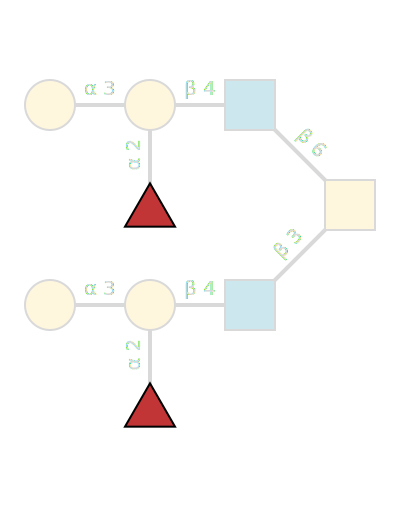

In [22]:
GlycoDraw("Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)GlcNAc(b1-6)]GalNAc", highlight_motif='Fuc')